Cepstral analysis is, to me, a promising alternative to spectral analysis in a variety of contexts, but especially machine learning. In this notebook I take a quick look at a spectrogram and cepstrogram of the first 30 seconds of "Carry On Wayward Son" by Kanasas to get a feel for what a cepstrum of music looks like, and what it might contain.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

First, load our raw audio data.

In [2]:
def load_u8(f, channels=2):
    return np.frombuffer(f.read(), dtype=np.uint8)

with open('kansas30.u8', 'rb') as f:
    kansas = load_u8(f) / 128. - 1.

kansas_L = kansas[0::2]
kansas_R = kansas[1::2]
sample_rate = 48000

Then we define a handful of helpful functions. `spectral_fn` and `cepstral_fn` define the two transformations we'll be doing. Notice that computing a cepstrum is just a matter of applying DFT of the log of the DFT, more or less. In other words, cepstrum is essentially a spectrum of a spectrum.

In [3]:
def gen_overlapping_windows(xs, n, pad=0.):
    for i in range(0, len(xs), n // 2):
        ys = xs[i:i+n]
        if n - len(ys) > 0:
            ys = np.pad(ys, (0, n - len(ys)), 'constant')
        yield ys
        
def easy_window_fn(xs):
    return np.sin(xs * np.pi) ** 2. 
        
def spectral_fn(xs):
    return np.abs(np.fft.fft(xs))

def cepstral_fn(xs):
    return np.abs(np.fft.fft(np.log(1.0 + np.abs(np.fft.fft(xs)))))

def gen_spectrogram(xs, spec=spectral_fn, window_size=2048, window_fn=easy_window_fn):
    w = window_fn(np.linspace(0., 1., window_size))
    for window in gen_overlapping_windows(xs, window_size):
        yield spec(window * w)

def spectrogram(xs, spec=spectral_fn, window_size=2048, window_fn=easy_window_fn):
    spectrum_len = 1 + (len(xs) * 2) // window_size
    ys = np.empty((spectrum_len, window_size))
    for (i, y) in enumerate(gen_spectrogram(xs, spec, window_size, window_fn)):
        ys[i] = y
    return ys

Fourier transforms are a popular tool for analyzing audio data of all kinds, including recorded music, often referred to as "spectral analysis". Frequently overlooked is cepstral analysis, which is, loosely speaking, spectral analysis of spectral analysis. This allows us to analyze periodic content of the spectrum, specifically overtones. Structures such as formants and noise show up in the cepstrum as low frequency content.

The graphs below show the spectrum, on the left, and cepstrum, on the right, of the first 30 seconds of "Carry On Wayward Son" by Kansas. (The axes are effectively arbitrary, for the purpose of this conversation.)

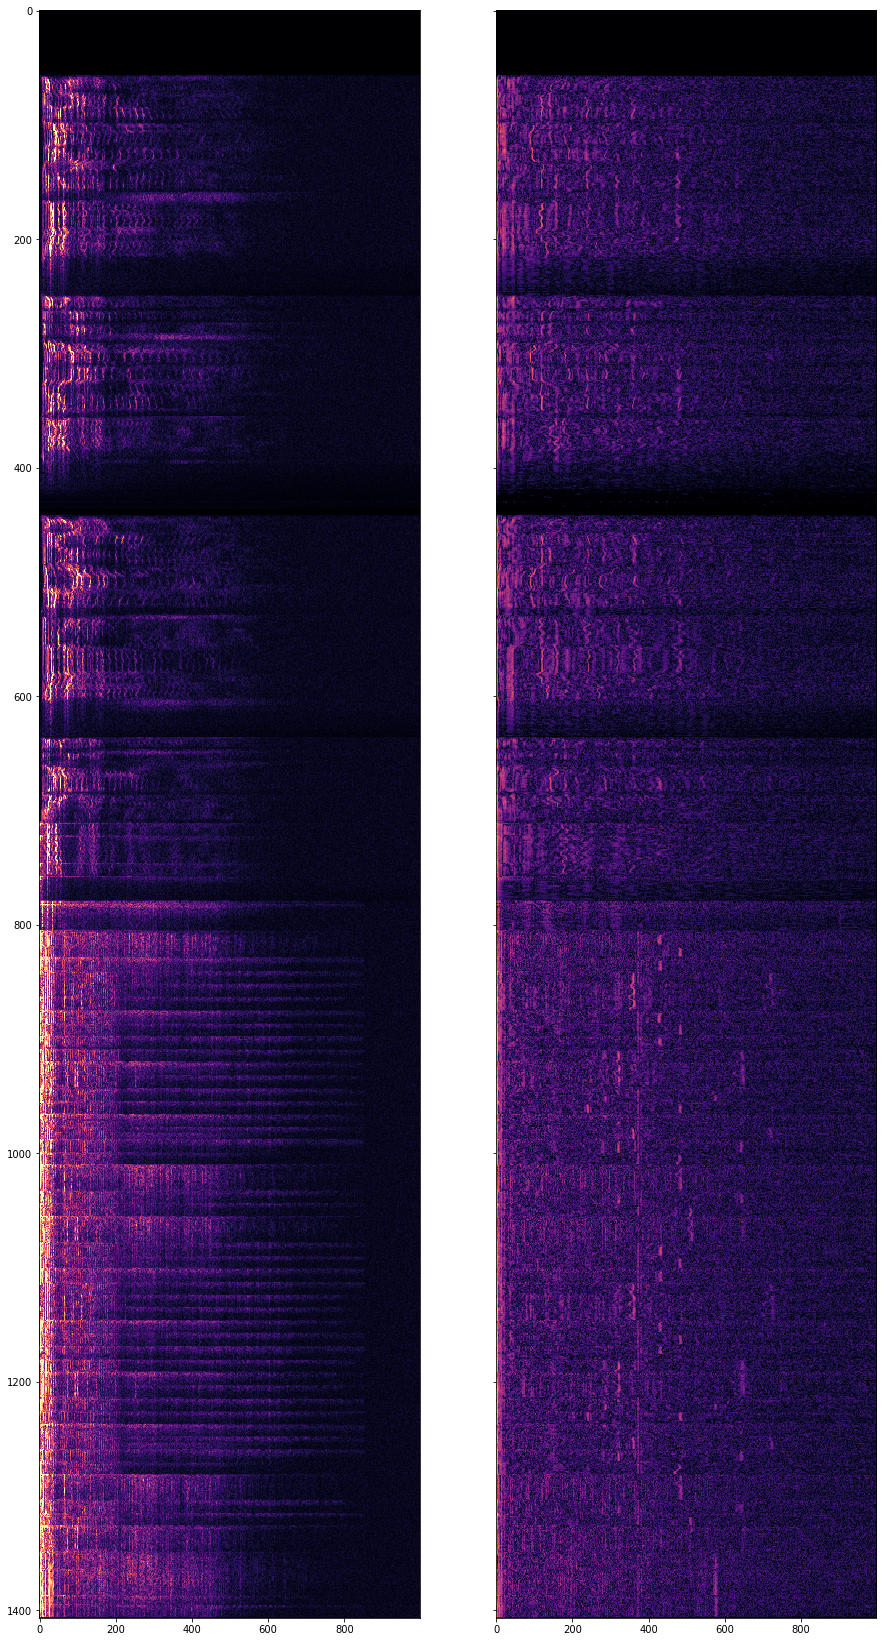

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,30))

ax1.imshow(spectrogram(kansas_L, spec=spectral_fn)[:,1:1000] ** 0.5, vmax= 4., cmap='magma', aspect=3.)
ax2.imshow(spectrogram(kansas_L, spec=cepstral_fn)[:,1:1000] ** 0.5, vmax=16., cmap='magma', aspect=3.)

While both the spectrum and cepstrum contain patterns, the ones in the cepstrum are less repetitive. This property makes me feel that applying machine learning techniques to the cepstrum is more likely to yield interesting results, due to the more focused nature of the features.